## Accessing Landsat 8 Collection 2 Level 2 data with the Planetary Computer STAC API

In [1]:
from pystac_client import API
import planetary_computer as pc

Define our area of interest. This area is in Redmond, around Microsoft's main campus.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}

We'll search all of 2020 for the least cloudy image of our area.

In [221]:
time_of_interest = "2020-01-01/2020-12-31"

Use [pystac_client](https://github.com/stac-utils/pystac-client) to perform the search:

In [222]:
api = API.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [223]:
search = api.search(
    collections=['landsat-8-c2-l2'], 
    intersects=area_of_interest, 
    datetime=time_of_interest    
)
print(f"{search.matched()} Items found")

47 Items found


We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [224]:
selected_item = sorted(search.items(), key=lambda item: item.ext.eo.cloud_cover)[0]

print(f"Choosing {selected_item.id} from {selected_item.datetime} with {selected_item.ext.eo.cloud_cover}% cloud cover")

Choosing LC08_L2SP_046027_20200908_20200919_02_T1 from 2020-09-08 18:55:51.575595+00:00 with 0.19% cloud cover


Here we use the [common name](https://github.com/stac-extensions/eo#common-band-names) of STAC's `eo` extension to choose the red, green and blue bands to render.

In [225]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = item.ext.eo.get_bands(asset)
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found!")

In [226]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, 'red').href,
    find_asset_by_band_common_name(selected_item, 'green').href,
    find_asset_by_band_common_name(selected_item, 'blue').href
]

This HREF is a URL is the location of the asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). In order to read the data, we'll need to retrieve a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and supply it as a query parameter. These tokens are generated from the Planetary Computer [Data Access API](https://planetarycomputer.microsoft.com/api/sas/v1/docs).

We use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to "sign" our asset HREF with a generated token:

In [227]:
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

We can now use the HREFs to read our data in any tools that can retrieve data from URLs via HTTP GET operations.

Here we use rasterio to render the image data over our area of interest.

In [148]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

In [196]:
def read_band(href):
    with rasterio.open(href) as ds:    
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)        

bands = [
    read_band(href)
    for href in signed_hrefs
]
    

The code above reads the [Cloud Optimized GeoTIFF](https://www.cogeo.org/) data for each of the red, green and blue bands. The band data is stored in separate images; we can use numpy's `stack` method to turn them into the equivalent of a multiband raster:

In [228]:
multiband_data = np.stack(bands)

The data is in uint16, which PIL will not render as-is. This code rescales the image to values between 0-255, changes the data type and renders our image:

In [229]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)

In [230]:
byte_data = rescaled.astype('ubyte')

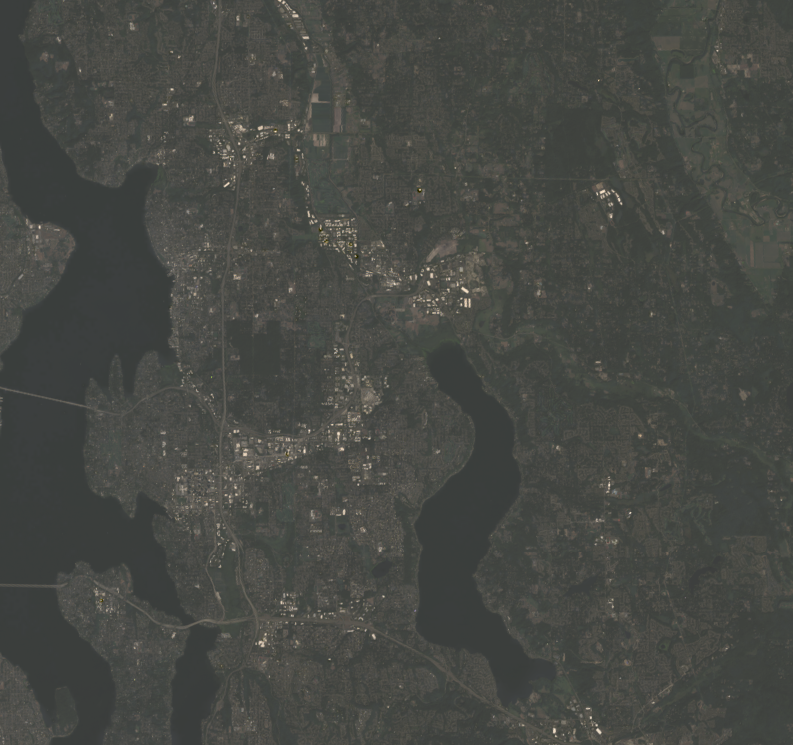

In [231]:
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

Landsat has several bands, and with them we can go beyond rendering RGB imagery; for example, the following code computes a [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using the near-infrared and red bands:

In [232]:
r = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, 'red').href)
).astype(float)

nir = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, 'nir08').href)
).astype(float)

In [233]:
ndvi = (nir - r) / (nir + r)

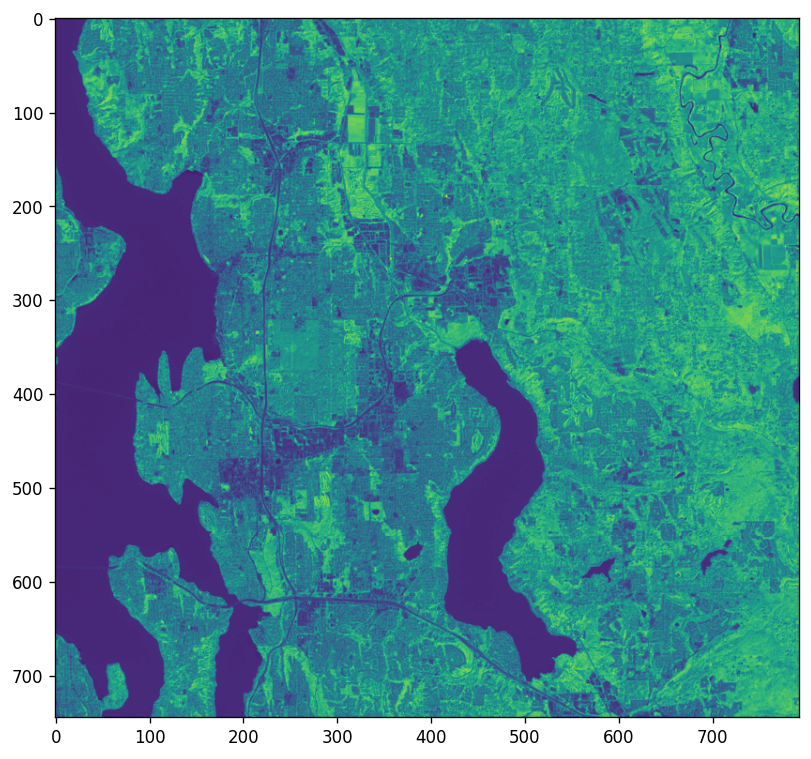

In [234]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=120)

plt.imshow(ndvi, cmap='viridis', )